In [1]:
!unzip d2d-data.zip

Archive:  d2d-data.zip
  inflating: specs.txt               
  inflating: d2d_ssf_UE1head_UE2pocket_NLOS_mv.txt  
  inflating: d2d_ssf_UE1texting_UE2head_LOS_mv.txt  
  inflating: D2D_UE1head_UE2head_NLOS_indoor_1khz_mv.txt  
  inflating: D2D_UE1head_UE2head_LOS_Indoor_1khz_mv.txt  
  inflating: d2d_ssf_UE1head_UE2pocket_LOS_mv.txt  
  inflating: D2D_UE1head_UE2head_NLOS_outdoor_1khz_mv.txt  


In [19]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import random
import math
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import special as sp
from scipy.stats import gaussian_kde
from scipy.io import loadmat
from sklearn.neighbors import KernelDensity
from scipy import special as sp
import warnings
warnings.filterwarnings('ignore')
import pdb
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Data Load

## D2D data

In [20]:
def D2D_data_linear():   
  """
  Data normalised with respect to their global means
  """
  UE1head_UE2head_LOS_indoor = pd.read_csv('/content/D2D_UE1head_UE2head_LOS_Indoor_1khz_mv.txt', delimiter = "\t", header=None)
  UE1head_UE2head_NLOS_indoor = pd.read_csv('/content/D2D_UE1head_UE2head_NLOS_indoor_1khz_mv.txt', delimiter = "\t", header=None)
  UE1head_UE2head_NLOS_outdoor = pd.read_csv('/content/D2D_UE1head_UE2head_NLOS_outdoor_1khz_mv.txt', delimiter = "\t", header=None)
    
  return UE1head_UE2head_LOS_indoor.T[500:10000].reset_index(drop=True), UE1head_UE2head_NLOS_indoor.T[500:10000].reset_index(drop=True),\
   UE1head_UE2head_NLOS_outdoor.T[500:10000].reset_index(drop=True)

def D2D_SSF_data_linear():   
  """
  Data normalised with respect to their local means (ssf)
  """
  UE1head_UE2pocket_LOS = pd.read_csv('/content/d2d_ssf_UE1head_UE2pocket_LOS_mv.txt', delimiter = "\t", header=None, )
  UE1head_UE2pocket_NLOS = pd.read_csv('/content/d2d_ssf_UE1head_UE2pocket_NLOS_mv.txt', delimiter = "\t", header=None)
  UE1text_UE2head_LOS = pd.read_csv('/content/d2d_ssf_UE1texting_UE2head_LOS_mv.txt', delimiter = "\t", header=None)

  return UE1head_UE2pocket_LOS.T, UE1head_UE2pocket_NLOS.T, UE1text_UE2head_LOS.T


##########################
#### LOAD GLOBAL MEAN ####
##########################
# SSF_pathAB_dB = pd.DataFrame()
UE1head_UE2head_LOS_indoor, \
UE1head_UE2head_NLOS_indoor, \
UE1head_UE2head_NLOS_outdoor = D2D_data_linear()

##########################
####  LOAD LOCAL MEAN ####
##########################
# SSF_pathAB_linear = pd.DataFrame()
UE1head_UE2pocket_LOS, \
UE1head_UE2pocket_NLOS, \
UE1text_UE2head_LOS = D2D_SSF_data_linear()


##########################
#### PRINT STATISTICS ####
##########################
print('Normalised wrt Global Mean')
print('UE1: Head | UE2: Head (LOS - Indoor) Statistics:')
display(UE1head_UE2head_LOS_indoor.describe())
print('UE1: Head | UE2: Head (NLOS - Indoor) Statistics:')
display(UE1head_UE2head_NLOS_indoor.describe())
print('UE1: Head | UE2: Head (NLOS - Outdoor) Statistics:')
display(UE1head_UE2head_NLOS_outdoor.describe())

print('Normalised wrt Local Mean')
print('UE1: Head | UE2: Pocket (LOS) Statistics:')
display(UE1head_UE2pocket_LOS.describe())
print('UE1: Head | UE2: Pocket (NLOS) Statistics:')
display(UE1head_UE2pocket_NLOS.describe())
print('UE1: Texting | UE2: Head (LOS) Statistics:')
display(UE1text_UE2head_LOS.describe())


Normalised wrt Global Mean
UE1: Head | UE2: Head (LOS - Indoor) Statistics:


,0
count,9500.000000
mean,0.921931
std,0.601470
min,0.017674
25%,0.508960
50%,0.773810
75%,1.185725
max,4.710200


UE1: Head | UE2: Head (NLOS - Indoor) Statistics:


,0
count,9500.000000
mean,0.995891
std,0.648062
min,0.012973
25%,0.498070
50%,0.875770
75%,1.381550
max,4.511200


UE1: Head | UE2: Head (NLOS - Outdoor) Statistics:


,0
count,9500.000000
mean,1.063997
std,0.682374
min,0.086185
25%,0.612620
50%,0.915005
75%,1.352000
max,4.497600


Normalised wrt Local Mean
UE1: Head | UE2: Pocket (LOS) Statistics:


,0
count,352.000000
mean,0.984655
std,0.325573
min,0.179790
25%,0.753408
50%,0.987740
75%,1.197825
max,2.244300


UE1: Head | UE2: Pocket (NLOS) Statistics:


,0
count,359.000000
mean,0.963644
std,0.263986
min,0.166430
25%,0.789900
50%,0.954080
75%,1.145800
max,1.933800


UE1: Texting | UE2: Head (LOS) Statistics:


,0
count,329.000000
mean,0.989625
std,0.269059
min,0.182660
25%,0.825610
50%,0.981770
75%,1.162800
max,1.812700


# Auxiliary Methods

In [21]:
def tic():
    #Homemade version of matlab tic and toc functions
    import time
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()

def toc():
    import time
    if 'startTime_for_tictoc' in globals():
        print("Elapsed time is " + str(time.time() - startTime_for_tictoc) + " seconds.")
    else:
        print("Toc: start time not set") 

def shadowedKappaMuPDF(r, kappa, mu, omega, md):
  '''
  shadowed kappa-mu pdf (type 1).
  '''
  A = 2 * r**((2*mu) -1) / omega**(mu)
  B = (mu**mu * md**md * (1+kappa)**mu) / (sp.gamma(mu) * ((mu*kappa)+md)**md)
  C = np.exp((- mu * (1+kappa) * r**2) / omega)
  D = (mu**2) * kappa * (1+kappa) * (r**2)
  E = ((mu*kappa)+md) * omega
  F = sp.hyp1f1(md, mu, D / E)

  pdf = A * B * C * F
  return pdf

def shadowedKappaMuPDF_t2(r, kappa, mu, r_hat, ms):
  '''
  shadowed kappa-mu pdf (type 2).
  '''
  A = 2 * ( ( ms - 1 ) ** ( ms ) ) * ( r ** ( ( 2 * mu ) - 1 ) )  * ( r_hat ** ( 2 * ms ) ) * ( ( 1 + kappa ) ** mu) * ( mu ** mu )
  B = sp.beta(ms, mu ) * ( ( ( (r ** 2) * (1 + kappa) * mu ) + ( ( r_hat ** 2 ) * ( ms - 1 + (kappa * mu) ) ) ) ** ( mu + ms ) )
  C = (ms+mu)/2
  D = (1+ms+mu)/2
  E = 4 * (mu**2) * kappa * (1 + kappa) * (r**2) * (r_hat**2)
  F = ( ( (r**2) * (1 + kappa) * mu ) + ( ( r_hat**2 ) * ( ms - 1 + (kappa * mu) ) ) )**2
  G = sp.hyp2f1( C, D, mu, E / F )

  pdf = (A/B)*G
  return pdf

def shadowedKappaMuPDF_t3(r, kappa, mu, r_hat, mt):
  '''
  shadowed kappa-mu pdf (type 3).
  '''
  A = 2 * ( ( 1 + kappa ) ** mu) * ( mu ** mu ) * math.exp( -kappa * mu ) * ( ( (mt - 1) * ( r_hat ** 2 ) )**( mt ) ) * ( r ** ( ( 2 * mu ) - 1 ) )
  B = sp.beta(mt, mu) * ( ( ( (r ** 2) * (1 + kappa) * mu ) + ( ( r_hat ** 2 ) * ( mt - 1 ) ) )**( mu + mt ) )
  C = (mt+mu)
  D = ( mu ** 2 ) * kappa * ( 1 + kappa ) * ( r**2)
  E = ( ( (r**2) * (1 + kappa) * mu ) + ( ( r_hat**2 ) * ( mt - 1 ) ) )
  F = sp.hyp1f1(C, mu, D/E )

  pdf = (A/B)*F
  return pdf

def kldiv(pVec1, pVec2):
  '''
  Kullback-Leibler divergence.
  '''
  KL = np.sum(pVec1*(np.log2(pVec1)-np.log2(pVec2)))
  return KL

def RAD(kldiv1, kldiv2):
  '''
  Resistor-Average Distance.
  '''
  RAD = 1/(1/kldiv1+1/kldiv2)
  return RAD

def getDensityEstimationSamples(linear_data, nExtractedSamples, case):
  '''
  Extracted KDE uniformly spaced samples from the data.
  '''
  Xdata = np.linspace(linear_data.min(), linear_data.max(), nExtractedSamples).reshape(-1, 1)
  kde = KernelDensity(kernel='gaussian', bandwidth=0.05).fit(linear_data.values.reshape(-1, 1))
  
  logkde = kde.score_samples(Xdata)
  Ydata = np.exp(logkde).reshape(-1,1)
  plt.figure(figsize=(10,7))
  plt.scatter(20*np.log10(Xdata), Ydata, c='magenta')
  plt.title(f'{case}')
  plt.ylabel('Density')
  plt.xlabel('Composite Fading (dB)')
  plt.grid()
  plt.show()
  return Xdata, Ydata

def printSummary(case, fitnessType):
  print('='*30+'\n'+'Genetic Algorithm Fitting\nFitness Type: {}\nCase: {}\n'.format(fitnessType, case))

def computeAIC(data, n, K, nls_skut1, nls_skut3, ga_skut1_mse, ga_skut1_rad,\
               ga_skut3_mse, ga_skut3_rad):

    # AIC NLS - SHADOWED KAPPA MU T1
    sum = np.sum(np.log(shadowedKappaMuPDF(data, nls_skut1[0], nls_skut1[1], nls_skut1[2], nls_skut1[3]).astype(float)))
    AIC_nls_shadowed_kappa_mu_t1 = -2*sum + 2*K + (2*K*(K+1))/(n-K-1)

    # AIC GENETIC ALGORITHM SHADOWED KAPPA MU T1 - FITNESS: MSE
    sum = np.sum(np.log(shadowedKappaMuPDF(data, ga_skut1_mse[0], ga_skut1_mse[1], ga_skut1_mse[2], ga_skut1_mse[3])))
    AIC_ga_shadowed_kappa_mu_t1 = -2*sum + 2*K + (2*K*(K+1))/(n-K-1)

    # AIC GENETIC ALGORITHM SHADOWED KAPPA MU T1 - FITNESS: RAD
    sum = np.sum(np.log(shadowedKappaMuPDF(data, ga_skut1_rad[0], ga_skut1_rad[1], ga_skut1_rad[2], ga_skut1_rad[3])))
    AIC_ga_shadowed_kappa_mu_t1_rad = -2*sum + 2*K + (2*K*(K+1))/(n-K-1)

    # # AIC NLS - SHADOWED KAPPA MU T2
    # sum = np.sum(np.log(shadowedKappaMuPDF_t2(data, nls_skut2[0], nls_skut2[1], nls_skut2[2], nls_skut2[3]).astype(float)))
    # AIC_nls_shadowed_kappa_mu_t2 = -2*sum + 2*K + (2*K*(K+1))/(n-K-1)

    # # AIC GENETIC ALGORITHM SHADOWED KAPPA MU T2 - FITNESS: MSE
    # sum = np.sum(np.log(shadowedKappaMuPDF_t2(data, ga_skut2_mse[0], ga_skut2_mse[1], ga_skut2_mse[2], ga_skut2_mse[3])))
    # AIC_ga_shadowed_kappa_mu_t2 = -2*sum + 2*K + (2*K*(K+1))/(n-K-1)

    # # AIC GENETIC ALGORITHM SHADOWED KAPPA MU T2 - FITNESS: RAD
    # sum = np.sum(np.log(shadowedKappaMuPDF_t2(data, ga_skut2_rad[0], ga_skut2_rad[1], ga_skut2_rad[2], ga_skut2_rad[3])))
    # AIC_ga_shadowed_kappa_mu_t2_rad = -2*sum + 2*K + (2*K*(K+1))/(n-K-1)

    # AIC NLS - SHADOWED KAPPA MU T3
    sum = np.sum(np.log(shadowedKappaMuPDF_t3(data, nls_skut3[0], nls_skut3[1], nls_skut3[2], nls_skut3[3]).astype(float)))
    AIC_nls_shadowed_kappa_mu_t3 = -2*sum + 2*K + (2*K*(K+1))/(n-K-1)

    # AIC GENETIC ALGORITHM SHADOWED KAPPA MU T3 - FITNESS: MSE
    sum = np.sum(np.log(shadowedKappaMuPDF_t3(data, ga_skut3_mse[0], ga_skut3_mse[1], ga_skut3_mse[2], ga_skut3_mse[3])))
    AIC_ga_shadowed_kappa_mu_t3 = -2*sum + 2*K + (2*K*(K+1))/(n-K-1)

    # AIC GENETIC ALGORITHM SHADOWED KAPPA MU T3 - FITNESS: RAD
    sum = np.sum(np.log(shadowedKappaMuPDF_t3(data, ga_skut3_rad[0], ga_skut3_rad[1], ga_skut3_rad[2], ga_skut3_rad[3])))
    AIC_ga_shadowed_kappa_mu_t3_rad = -2*sum + 2*K + (2*K*(K+1))/(n-K-1)

    rads = {'Methods':['NLS - Shad. KappaMu T1', 'GA - Shad. KappaMu T1 (Fitness = MSE)',\
                       'GA - Shad. KappaMu T1 (Fitness = RAD)',\
                      #  'NLS - Shad. KappaMu T2', 'GA - Shad. KappaMu T2 (Fitness = MSE)',\
                      #  'GA - Shad. KappaMu T2 (Fitness = RAD)',\
                       'NLS - Shad. KappaMu T3', 'GA - Shad. KappaMu T3 (Fitness = MSE)',\
                       'GA - Shad. KappaMu T3 (Fitness = RAD)'],
        'Akaike Information Criteria':[AIC_nls_shadowed_kappa_mu_t1[0], AIC_ga_shadowed_kappa_mu_t1[0], AIC_ga_shadowed_kappa_mu_t1_rad[0],\
                                      #  AIC_nls_shadowed_kappa_mu_t2[0], AIC_ga_shadowed_kappa_mu_t2[0], AIC_ga_shadowed_kappa_mu_t2_rad[0],\
                                       AIC_nls_shadowed_kappa_mu_t3[0], AIC_ga_shadowed_kappa_mu_t3[0], AIC_ga_shadowed_kappa_mu_t3_rad[0]]}
    
    df = pd.DataFrame(rads)
    display(df.sort_values(by='Akaike Information Criteria').reset_index(drop=True))
    
    return df

def plotResults(Xdata, Ydata, sku_t1_pdf, sku_t3_pdf, \
                ga_sku_t1_mse, ga_sku_t1_rad, \
                # ga_sku_t2_mse, ga_sku_t2_rad, \
                ga_sku_t3_mse, ga_sku_t3_rad, case):
    plt.figure(figsize=((10,7)))
    plt.scatter(20*np.log10(Xdata), Ydata, c='black')
    plt.plot(20*np.log10(Xdata), sku_t1_pdf, label=r'Shad. $\kappa$-$\mu$ (Type 1) NLS')
    # plt.plot(20*np.log10(Xdata), sku_t2_pdf, label=r'Shad. $\kappa$-$\mu$ (Type 2) NLS')
    plt.plot(20*np.log10(Xdata), sku_t3_pdf, label=r'Shad. $\kappa$-$\mu$ (Type 3) NLS')
    plt.plot(20*np.log10(Xdata), shadowedKappaMuPDF(Xdata, ga_sku_t1_mse[0], ga_sku_t1_mse[1], ga_sku_t1_mse[2], ga_sku_t1_mse[3]), label='GA: Shad. $\kappa$-$\mu$ (Type 1) (MSE)')
    # plt.plot(20*np.log10(Xdata), shadowedKappaMuPDF_t2(Xdata, ga_sku_t2_mse[0], ga_sku_t2_mse[1], ga_sku_t2_mse[2], ga_sku_t2_mse[3]), label='GA: Shad. $\kappa$-$\mu$ (Type 2) (MSE)')
    plt.plot(20*np.log10(Xdata), shadowedKappaMuPDF_t3(Xdata, ga_sku_t3_mse[0], ga_sku_t3_mse[1], ga_sku_t3_mse[2], ga_sku_t3_mse[3]), label='GA: Shad. $\kappa$-$\mu$ (Type 3) (MSE)')
    plt.plot(20*np.log10(Xdata), shadowedKappaMuPDF(Xdata, ga_sku_t1_rad[0], ga_sku_t1_rad[1], ga_sku_t1_rad[2], ga_sku_t1_rad[3]), label='GA: Shad. $\kappa$-$\mu$ (Type 1) (RAD)')
    # plt.plot(20*np.log10(Xdata), shadowedKappaMuPDF_t2(Xdata, ga_sku_t2_rad[0], ga_sku_t2_rad[1], ga_sku_t2_rad[2], ga_sku_t2_rad[3]), label='GA: Shad. $\kappa$-$\mu$ (Type 2) (RAD)')
    plt.plot(20*np.log10(Xdata), shadowedKappaMuPDF_t3(Xdata, ga_sku_t3_rad[0], ga_sku_t3_rad[1], ga_sku_t3_rad[2], ga_sku_t3_rad[3]), label='GA: Shad. $\kappa$-$\mu$ (Type 3) (RAD)')
    plt.title(f'{case}')
    plt.legend()
    plt.grid(True)
    plt.xlabel(r'Composite Fading (dB)')
    plt.ylabel('Density')
    plt.savefig('(dB) sku_t1_t3_case_{}.pdf'.format(case, dpi=150))
    plt.show()
    
    plt.figure(figsize=((10,7)))
    plt.scatter(Xdata, Ydata, c='black')
    plt.plot(Xdata, sku_t1_pdf, label=r'Shad. $\kappa$-$\mu$ (Type 1) NLS')
    # plt.plot(Xdata, sku_t2_pdf, label=r'Shad. $\kappa$-$\mu$ (Type 2) NLS')
    plt.plot(Xdata, sku_t3_pdf, label=r'Shad. $\kappa$-$\mu$ (Type 3) NLS')
    plt.plot(Xdata, shadowedKappaMuPDF(Xdata, ga_sku_t1_mse[0], ga_sku_t1_mse[1], ga_sku_t1_mse[2], ga_sku_t1_mse[3]), label='GA: Shad. $\kappa$-$\mu$ (Type 1) (MSE)')
    # plt.plot(Xdata, shadowedKappaMuPDF_t2(Xdata, ga_sku_t2_mse[0], ga_sku_t2_mse[1], ga_sku_t2_mse[2], ga_sku_t2_mse[3]), label='GA: Shad. $\kappa$-$\mu$ (Type 2) (MSE)')
    plt.plot(Xdata, shadowedKappaMuPDF_t3(Xdata, ga_sku_t3_mse[0], ga_sku_t3_mse[1], ga_sku_t3_mse[2], ga_sku_t3_mse[3]), label='GA: Shad. $\kappa$-$\mu$ (Type 3) (MSE)')
    plt.plot(Xdata, shadowedKappaMuPDF(Xdata, ga_sku_t1_rad[0], ga_sku_t1_rad[1], ga_sku_t1_rad[2], ga_sku_t1_rad[3]), label='GA: Shad. $\kappa$-$\mu$ (Type 1) (RAD)')
    # plt.plot(Xdata, shadowedKappaMuPDF_t2(Xdata, ga_sku_t2_rad[0], ga_sku_t2_rad[1], ga_sku_t2_rad[2], ga_sku_t2_rad[3]), label='GA: Shad. $\kappa$-$\mu$ (Type 2) (RAD)')
    plt.plot(Xdata, shadowedKappaMuPDF_t3(Xdata, ga_sku_t3_rad[0], ga_sku_t3_rad[1], ga_sku_t3_rad[2], ga_sku_t3_rad[3]), label='GA: Shad. $\kappa$-$\mu$ (Type 3) (RAD)')
    plt.title(f'{case}')
    plt.legend()
    plt.grid(True)
    plt.xlabel(r'Composite Fading (linear)')
    plt.ylabel('Density')
    plt.savefig('(linear) sku_t1_t3_case_{}.pdf'.format(case, dpi=150))
    plt.show()

In [55]:
!rm *.png
!rm *.gif

rm: cannot remove '*.gif': No such file or directory


# Shadowed $\kappa$-$\mu$ : GA fitting 



In [56]:
def fitness_skut1(X, Y, fitnessType, kappa, mu, omega, md):
  '''
  Fitness function (MSE/RAD) to determine how good a given solution is.
  (Shadowed Kappa Mu Type 1)
  '''
  if fitnessType == 'MSE':
    y_pred = shadowedKappaMuPDF(X, kappa, mu, omega, md)
    n = len(Y)
    sum = []
    for val in (Y-y_pred):
      sum.append(val**2)
    sum = np.sum(sum)
    cost = 1/n * sum
    return 1/cost
  elif fitnessType == 'RAD':
    pVec1 = Y/np.sum(Y)
    pVec2 = shadowedKappaMuPDF(X, kappa, mu, omega, md)/np.sum(shadowedKappaMuPDF(X, kappa, mu, omega, md))
    KLD_1 = kldiv(pVec1, pVec2)
    KLD_2 = kldiv(pVec2, pVec1)
    cost = RAD(KLD_1, KLD_2)
    return 1/cost


def geneticAlgorithm_skut1(X, Y, threshold, firstFlag=True, printPerGen=False):
  '''
  Genetic Algorithm incorporating Shadowed Kappa Mu Type 1 in the Fitness Function
  It fits kappa, mu, omega, md
  '''
  if firstFlag:
    tic()
    printPerGen=printPerGen
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('$\kappa$')
    ax.set_ylabel('$\mu$')
    ax.set_zlabel('$\omega$')

  filenames = []
  filenames_dist = []
  solutions = []
  bestParams = []
  bestCriteria = 0
  bestGen = 0


  # Generate solutions (chromossomes)
  for s in range(nPopulation):
    solutions.append((random.uniform(0.01, 11), # kappa
                        random.uniform(0.01, 3.0), # mu
                        random.uniform(0.01, 3.0), # r_hat^2
                        random.uniform(0.01, 20.0))) # md

  # Evolutionary Loop
  for i in range(nMaxGen):
    rankedSolutions = []
    for s in solutions:
      rankedSolutions.append( (fitness_skut1(X, Y, fitnessType, s[0],s[1],s[2],s[3]), s) )
    rankedSolutions.sort()
    rankedSolutions.reverse()

    if printPerGen:  
      print(f'=== Generation: {i} === ')
      print(f'Fitness: {rankedSolutions[0][0]}')
      print('Best individual:')
      print(f'Kappa: {rankedSolutions[0][1][0]}')
      print(f'Mu: {rankedSolutions[0][1][1]}')
      print(f'Omega: {rankedSolutions[0][1][2]}')
      print(f'Md: {rankedSolutions[0][1][3]}\n')

    filename = f'{i}.png'
    filenames.append(filename)

    filename_dist = f'dist_{i}.png'
    filenames_dist.append(filename_dist)
    if i > 0:
      ax.scatter(rankedSolutions[0][1][0],rankedSolutions[0][1][1],rankedSolutions[0][1][2], c='blue', alpha=0.4)
    elif i > 30:
      ax.scatter(rankedSolutions[0][1][0],rankedSolutions[0][1][1],rankedSolutions[0][1][2], c='blue', alpha=0.6)
    elif i > 60:
      ax.scatter(rankedSolutions[0][1][0],rankedSolutions[0][1][1],rankedSolutions[0][1][2], c='blue', alpha=0.8)
    else:
      ax.scatter(rankedSolutions[0][1][0],rankedSolutions[0][1][1],rankedSolutions[0][1][2], c='blue', alpha=0.99)
    plt.savefig(filename)

    plt.figure()
    plt.scatter(20*np.log10(X), Y, c='magenta')
    plt.plot(20*np.log10(X), shadowedKappaMuPDF(X, rankedSolutions[0][1][0],rankedSolutions[0][1][1],rankedSolutions[0][1][2],rankedSolutions[0][1][3]), label='GA: Shad. $\kappa$-$\mu$ (MSE)')
    plt.legend()
    plt.savefig(filename_dist)
    plt.close()
    # ax.remove()
    # if i > 2:
    #   ax.lines[0].remove()
    #   ax.collections[0].remove()
    # Keeping track the best params and generation:
    if rankedSolutions[0][0] > bestCriteria:
      bestCriteria = rankedSolutions[0][0]
      bestGen = i
      bestParams = rankedSolutions[0][1]

    # Check if it is good enough according to a satisfactory threshold:
    if bestCriteria > threshold:
      print('Satisfactory Threshold reached!')  
      toc()
      print('\nBest Fitness: {}\nBest Gen: {}'.format(bestCriteria, bestGen))
      print('Kappa: {}\nMu: {}\nOmega: {}\nMd: {}'.format(bestParams[0],bestParams[1],bestParams[2],bestParams[3]))
      ax.scatter(bestParams[0],bestParams[1],bestParams[2], c='red', marker='*')
      plt.savefig('last.png'.format(case, dpi=150))
      filenames.append('last.png')
      plt.figure()
      plt.scatter(20*np.log10(X), Y, c='magenta')
      plt.plot(20*np.log10(X), shadowedKappaMuPDF(X, rankedSolutions[0][1][0],rankedSolutions[0][1][1],rankedSolutions[0][1][2],rankedSolutions[0][1][3]), label='GA: Shad. $\kappa$-$\mu$ (MSE)')
      plt.legend()
      plt.savefig('last_dist.png'.format(case, dpi=150))
      filenames_dist.append('last_dist.png')
      plt.close()
      

    
      return filenames, filenames_dist, bestParams[0],bestParams[1],bestParams[2],bestParams[3]
    
    # Combine the best solutions and make a new solution of those combined solutions
    bestSolutions = rankedSolutions[:100]
    elements_kappa = []
    elements_mu = []
    elements_omega = [] 
    elements_md = [] 
    for s in bestSolutions:
      elements_kappa.append(s[1][0])
      elements_mu.append(s[1][1])
      elements_omega.append(s[1][2])
      elements_md.append(s[1][3])

    newGen = []
    for _ in range(nPopulation):
      e1 = random.choice(elements_kappa) * random.uniform(0.975,1.025) # Mutation of 5%
      e2 = random.choice(elements_mu) * random.uniform(0.975,1.025) # Mutation of 5%
      e3 = random.choice(elements_omega) * random.uniform(0.975,1.025) # Mutation of 5%
      e4 = random.choice(elements_md) * random.uniform(0.975,1.025) # Mutation of 5%
      
      newGen.append((e1,e2,e3,e4))

    solutions = newGen
    
    if i == nMaxGen-1:
      # print('Max number of generations reached! (Possible bad initialization)\nRestarting...\n')
      b0, b1, b2, b3 = geneticAlgorithm_skut1(X, Y, threshold, False, printPerGen)
        
      return b0, b1, b2, b3

# Composite Fading Fitting (PARAMETERS)

In [57]:
### PARAMETERS
nMaxGen = 20
nPopulation = 1000
nExtractedSamples = 81

### D2D UE1 head - UE2 head NLOS (outdoor) [Case 3]

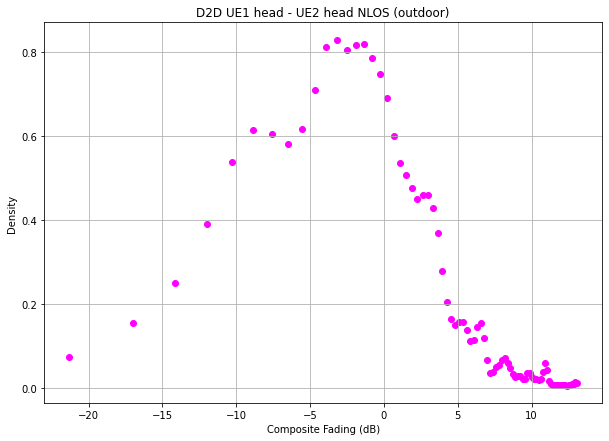

In [58]:
case = 'D2D UE1 head - UE2 head NLOS (outdoor)'
estParameters_sku_t1_t3_case3 = pd.DataFrame()
Xdata, Ydata = getDensityEstimationSamples(UE1head_UE2head_NLOS_outdoor.dropna(), nExtractedSamples, case)

============================== SHADOWED KAPPA-MU T1 ==============================
Genetic Algorithm Fitting
Fitness Type: MSE
Case: D2D UE1 head - UE2 head NLOS (outdoor)

=== Generation: 0 === 
Fitness: nan
Best individual:
Kappa: 9.605905348863443
Mu: 2.625835844332531
Omega: 0.21370135447390617
Md: 9.204573984285755

=== Generation: 1 === 
Fitness: nan
Best individual:
Kappa: 8.309803761466823
Mu: 1.175621884058302
Omega: 0.1634061405457411
Md: 8.169644795278552

=== Generation: 2 === 
Fitness: nan
Best individual:
Kappa: 7.126729693053119
Mu: 2.410235371173316
Omega: 0.18439326045742876
Md: 0.4402160949162535

=== Generation: 3 === 
Fitness: nan
Best individual:
Kappa: 7.147145934254025
Mu: 2.4557748409978024
Omega: 0.16113411414993997
Md: 3.4100688856711807

=== Generation: 4 === 
Fitness: 557.6061423670288
Best individual:
Kappa: 1.47496419129051
Mu: 1.0410953058691237
Omega: 1.3300266254282846
Md: 0.4438337142120675

=== Generation: 5 === 
Fitness: 678.9823754688224
Best indivi

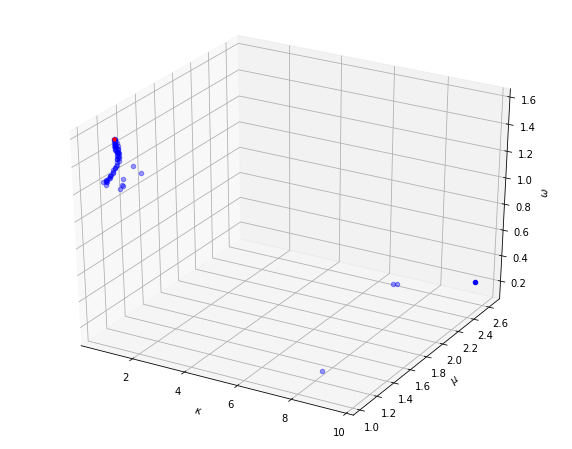

In [59]:
nMaxGen = 100

print('='*30+' SHADOWED KAPPA-MU T1 '+'='*30)
fitnessType = 'MSE'
printSummary(case, fitnessType)
filenames, filenames_dist, sku_t1_kappa_mse, sku_t1_mu_mse, sku_t1_r_hat_mse, sku_t1_mt_mse = geneticAlgorithm_skut1(Xdata, Ydata, 870, printPerGen=True) 

# fitnessType = 'RAD'
# printSummary(case, fitnessType)
# sku_t1_kappa_rad, sku_t1_mu_rad, sku_t1_r_hat_rad, sku_t1_mt_rad = geneticAlgorithm_skut1(Xdata, Ydata, 110)

# print('='*30+' SHADOWED KAPPA-MU T3 '+'='*30)
# fitnessType = 'MSE'
# printSummary(case, fitnessType)
# sku_t3_kappa_mse, sku_t3_mu_mse, sku_t3_r_hat_mse, sku_t3_mt_mse = geneticAlgorithm_skut3(Xdata, Ydata, 822)

# fitnessType = 'RAD'
# printSummary(case, fitnessType)
# sku_t3_kappa_rad, sku_t3_mu_rad, sku_t3_r_hat_rad, sku_t3_mt_rad = geneticAlgorithm_skut3(Xdata, Ydata, 95)

In [76]:
import os
import numpy as np
import matplotlib.pyplot as plt
import imageio

In [77]:
with imageio.get_writer('mygif.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        if filename == 'last.png':
          writer.append_data(imageio.imread(filename))
        else:
           writer.append_data(image)
    for _ in range(15):
      writer.append_data(imageio.imread('last.png'))

In [78]:
with imageio.get_writer('mygif_dist.gif', mode='I') as writer:
    for filename in filenames_dist:
        image = imageio.imread(filename)
        if filename == 'last_dist.png':
          writer.append_data(imageio.imread(filename))
        else:
           writer.append_data(image)
    for _ in range(15):
      writer.append_data(imageio.imread('last_dist.png'))

In [80]:
!pip install imageio-ffmpeg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 26.9 MB 1.3 MB/s 


In [81]:
with imageio.get_writer('test.mp4', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        if filename == 'last.png':
          writer.append_data(imageio.imread(filename))
        else:
           writer.append_data(image)
    for _ in range(15):
      writer.append_data(imageio.imread('last.png'))

In [83]:
with imageio.get_writer('test_dist.mp4', mode='I') as writer:
    for filename in filenames_dist:
        image = imageio.imread(filename)
        if filename == 'last_dist.png':
          writer.append_data(imageio.imread(filename))
        else:
           writer.append_data(image)
    for _ in range(15):
      writer.append_data(imageio.imread('last_dist.png'))